In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import IsolationForest

### Outlier Detection 
Financial data consisting of: 
- member_unique_id - member's ID
- gender - member's gender
- dob - member's date of birth
- eligible_year - year
- eligible_month - month
- affiliation_type - doctor's type
- pbp_group - health plan group
- plan_name - health plan name
- npi - doctor's ID
- line_of_business - health plan type
- esrd - True if patient is on dialysis
- hospice - True if patient is in hospice

**Remaining columns are all financial indicators**

In [2]:
# 10530 data points, 28 features
# 3924 NaN values for feature plan_name
insurance_data = pd.read_csv("/Users/brandonwu/Downloads/datasets/sfr_test.csv")
insurance_data_original = insurance_data.copy() # Keep a reference of non-transformed values
print(f"Structure of data: {insurance_data.shape}")
print(f"Features: {insurance_data.columns}")

categorical_variables = set(["member_unique_id", "gender", "dob", "eligible_year", "eligible_month", "affiliation_type", 
                         "pbp_group", "plan_name", "npi", "line_of_business", "esrd", "hospice"])

total_columns = set(insurance_data.columns)
remaining = total_columns - categorical_variables


Structure of data: (10530, 28)
Features: Index(['member_unique_id', 'gender', 'dob', 'eligible_year', 'eligible_month',
       'affiliation_type', 'pbp_group', 'plan_name', 'npi', 'line_of_business',
       'esrd', 'hospice', 'ipa_funding', 'ma_premium', 'ma_risk_score',
       'mbr_with_rx_rebates', 'partd_premium', 'pcp_cap', 'pcp_ffs',
       'plan_premium', 'prof', 'reinsurance', 'risk_score_partd', 'rx',
       'rx_rebates', 'rx_with_rebates', 'rx_without_rebates', 'spec_cap'],
      dtype='object')


### Features Elligible for Outlier Detection
- rx_with_rebates
- ma_risk_score 
- rx 
- ipa_funding 
- ma_premium 
- pcp_ffs 
- partd_premium 
- reinsurance 
- rx_rebates 
- rx_without_rebates 
- prof 
- pcp_cap 
- plan_premium 
- mbr_with_rx_rebates 
- spec_cap 
- risk_score_partd

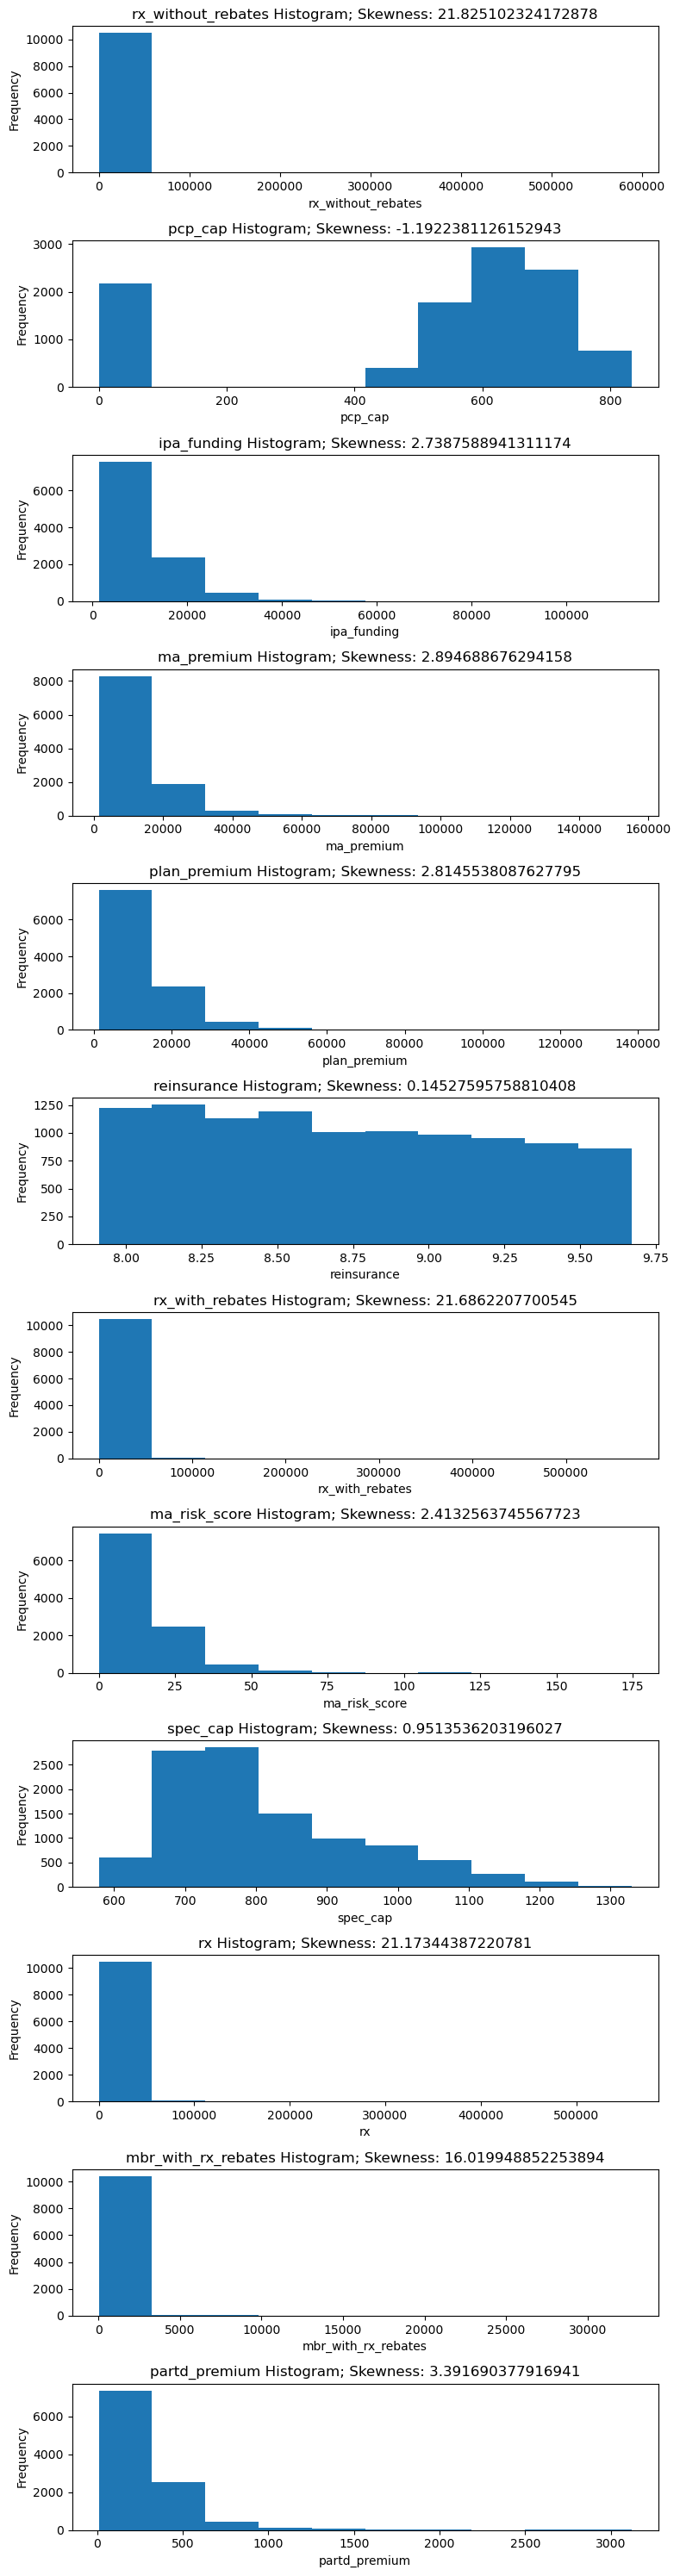

In [3]:
features = ["rx_without_rebates", "pcp_cap", "ipa_funding", "ma_premium", "plan_premium", "reinsurance", 
            "rx_with_rebates", "ma_risk_score", "spec_cap", "rx", "mbr_with_rx_rebates", "partd_premium"]

fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(8, 30))

# Plot histograms of features to analyze skewness

for i, feature in enumerate(features):
    # Transform data from type "object" to float
    insurance_data[feature] = insurance_data[feature].replace("[\$,]", "", regex=True).astype(float)
    skew = insurance_data[feature].skew()
    axes[i].hist(insurance_data[feature])
    axes[i].set_xlabel(f"{feature}")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"{feature} Histogram; Skewness: {skew}")

plt.tight_layout()
plt.show()


### Initial Approach to Handling Skewed Data
- Apply log transformations to right skewed data
- Apply square root transformations to left skewed data

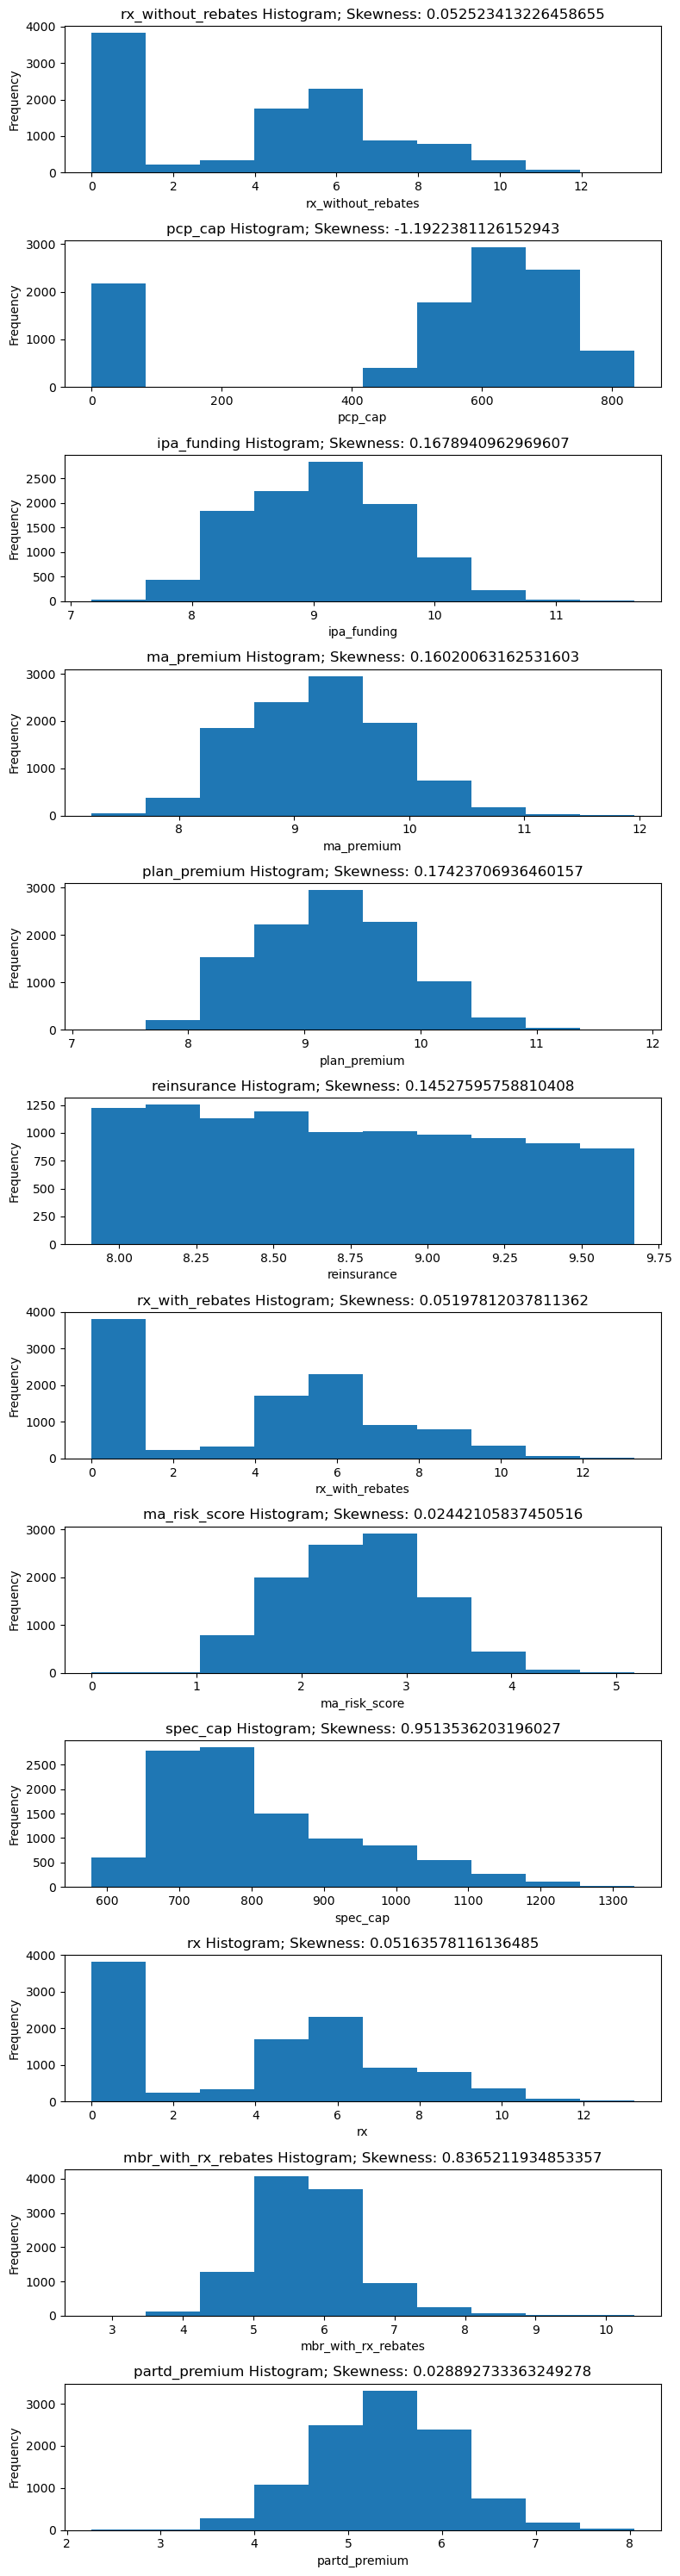

In [4]:
def apply_transformation(data, column):
    """Apply transformation to mitigate extreme skewness of data"""
    data[column] = data[column].replace("[\$,]", "", regex=True).astype(float)
    skew = data[column].skew()
    if skew > 1:
        data[column] = np.log1p(data[column])


# Do not account for left skew since all transformations have made left skewness worse
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(8, 30))
for i, feature in enumerate(features):
    apply_transformation(insurance_data, feature)
    skew = insurance_data[feature].skew()
    axes[i].hist(insurance_data[feature])
    axes[i].set_xlabel(f"{feature}")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"{feature} Histogram; Skewness: {skew}")
    
plt.tight_layout()
plt.show()



### Results of Data Transformation
- Majority of right skewed data had a skew between -1 and 1
- pcp_cap still slightly left skewed (-1.19)
- pcp_ffs is still severely skewed (8.87 to 4.94)
- prof still skewed (12.62 to 1.83)

### Approach to Detecting Outliers
- For normalized data with a skew in range [-1, 1] find the IQR and determine a datapoint an outlier if it is less than q1 - 1.5 * IQR or greater than q3 + 1.5 * IQR
- For data that still has a skew less than -1 or greater than 1, use robust z-score

In [5]:
def idenfity_outlier_normalized(data, column):
    """Takes a single feature (transformed) and identifies outliers with skew in range [-1, 1]"""
    outliers = []
    iqr = stats.iqr(data[column])
    q1, q3 = np.percentile(data[column], 25), np.percentile(data[column], 75)
    # Return a list of indices containing outliers
    for i, val in enumerate(data[column]):
        if val < (q1 - 1.5 * iqr) or val > (q3 + 1.5 * iqr):
            outliers.append(i)
    return outliers


# Use robust z-scores to find outliers for skewed data after transformation
# Z = X - Median / MAD, where MAD = median absolute deviation
def identify_outlier_skewed(data, column):
    """Takes a single feature that is skewed after transformation and identifies outliers"""
    MAD = stats.median_abs_deviation(data[column])
    median = data[column].median()
    outliers = []
    for i, val in enumerate(data[column]):
        robust_z_score = (val - median) / MAD
        if abs(robust_z_score) > 3:
            outliers.append(i)
    return outliers
    

def classify_outlier(data, column):
    """Call appropriate outlier identification method based on skew"""
    if -1 < data[column].skew() < 1:
        outliers = idenfity_outlier_normalized(data, column)
    else:
        outliers = identify_outlier_skewed(data, column)
    return outliers


def get_outlier_values(column, outliers):
    """Maps outlier indices to their values"""
    outlier_values = []
    for index in outliers:
        outlier_values.append(insurance_data_original[column][index])
    return outlier_values


In [6]:
# Create a dictionary with key being the feature and value being a list of indices of outliers
insurance_data_outliers = {}
for col in features:
    # Find indices of outliers
    outlier_idx = classify_outlier(insurance_data, col)
    insurance_data_outliers[col] = outlier_idx


def to_float(data, column):
    """Convert numeric strings to type float"""
    data[column] = data[column].replace("[\$,]", "", regex=True).astype(float)


for key in insurance_data_outliers.keys():
    print(f"Feature: {key}")
    print(insurance_data_outliers[key])


Feature: rx_without_rebates
[]
Feature: pcp_cap
[372, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 7

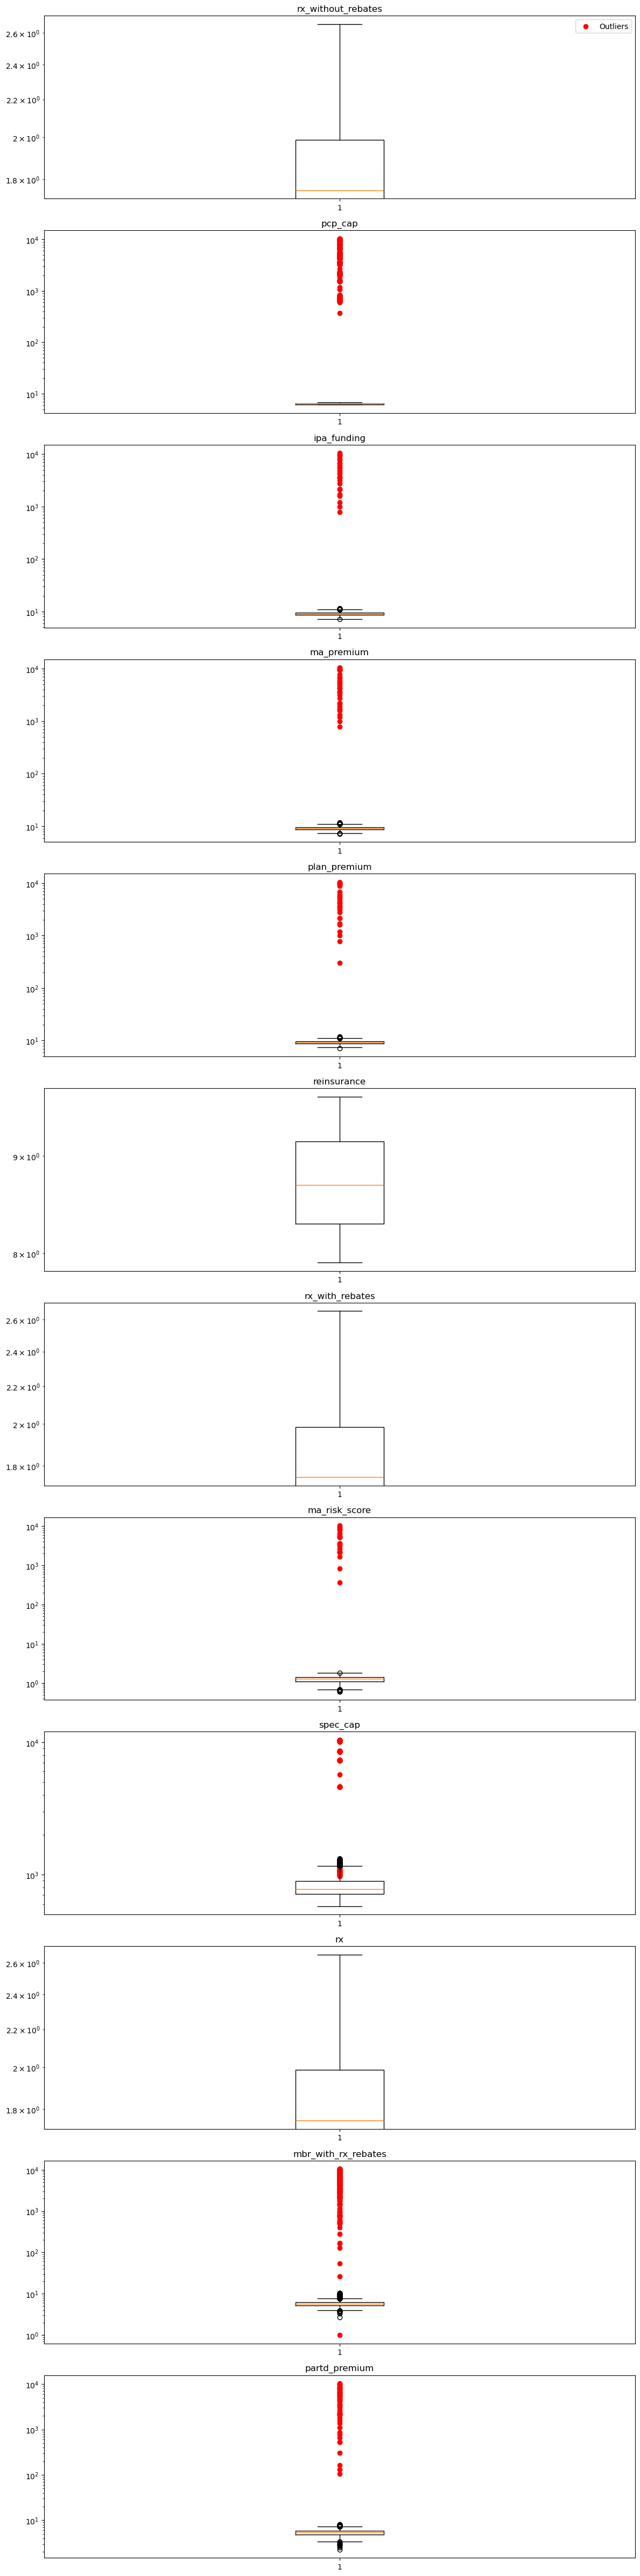

In [14]:
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(12, len(features) * 4))

for i, col in enumerate(features):
    if (insurance_data[col] <= 0).any():
        insurance_data[col] = np.log1p(insurance_data[col])  # Safe log transformation
    
    axes[i].set_yscale("log")  
    axes[i].boxplot(insurance_data[col])
    axes[i].scatter([1] * len(insurance_data_outliers[col]), insurance_data_outliers[col], color='red', label='Outliers')
    axes[i].set_title(col)

    if i == 0:  # Only show legend once
        axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()


### Tricky Data
- rx_rebates and risk_score_partd have 0 skew, so it is impossible to have an outlier
- pcp_ffs and prof have a MAD of 0 after transformation, leading to division by zero error

In [20]:
# pcp_ffs and prof
insurance_data["pcp_ffs"] = insurance_data["pcp_ffs"].replace("[\$,]", "", regex=True).astype(float)
insurance_data["prof"] = insurance_data["prof"].replace("[\$,]", "", regex=True).astype(float)

pcp_ffs = insurance_data["pcp_ffs"]
prof = insurance_data["prof"]

X_pcp_ffs = pd.DataFrame({"pcp_ffs" : pcp_ffs})
X_prof = pd.DataFrame({"prof" : prof})

learner_pcp_ffs = IsolationForest(contamination="auto")
learner_prof = IsolationForest(contamination="auto")

learner_pcp_ffs.fit(X_pcp_ffs)
learner_prof.fit(X_prof)


IsolationForest()

In [ ]:
predictions_pcp_ffs = learner_pcp_ffs.predict(X_pcp_ffs)
predictions_prof = learner_prof.predict(X_prof)

print(f"Results for pcp_ffs: {predictions_pcp_ffs}")
print(f"Results for prof: {predictions_prof}")

Results for pcp_ffs: [1 1 1 ... 1 1 1]
Results for prof: [ 1  1  1 ...  1 -1  1]


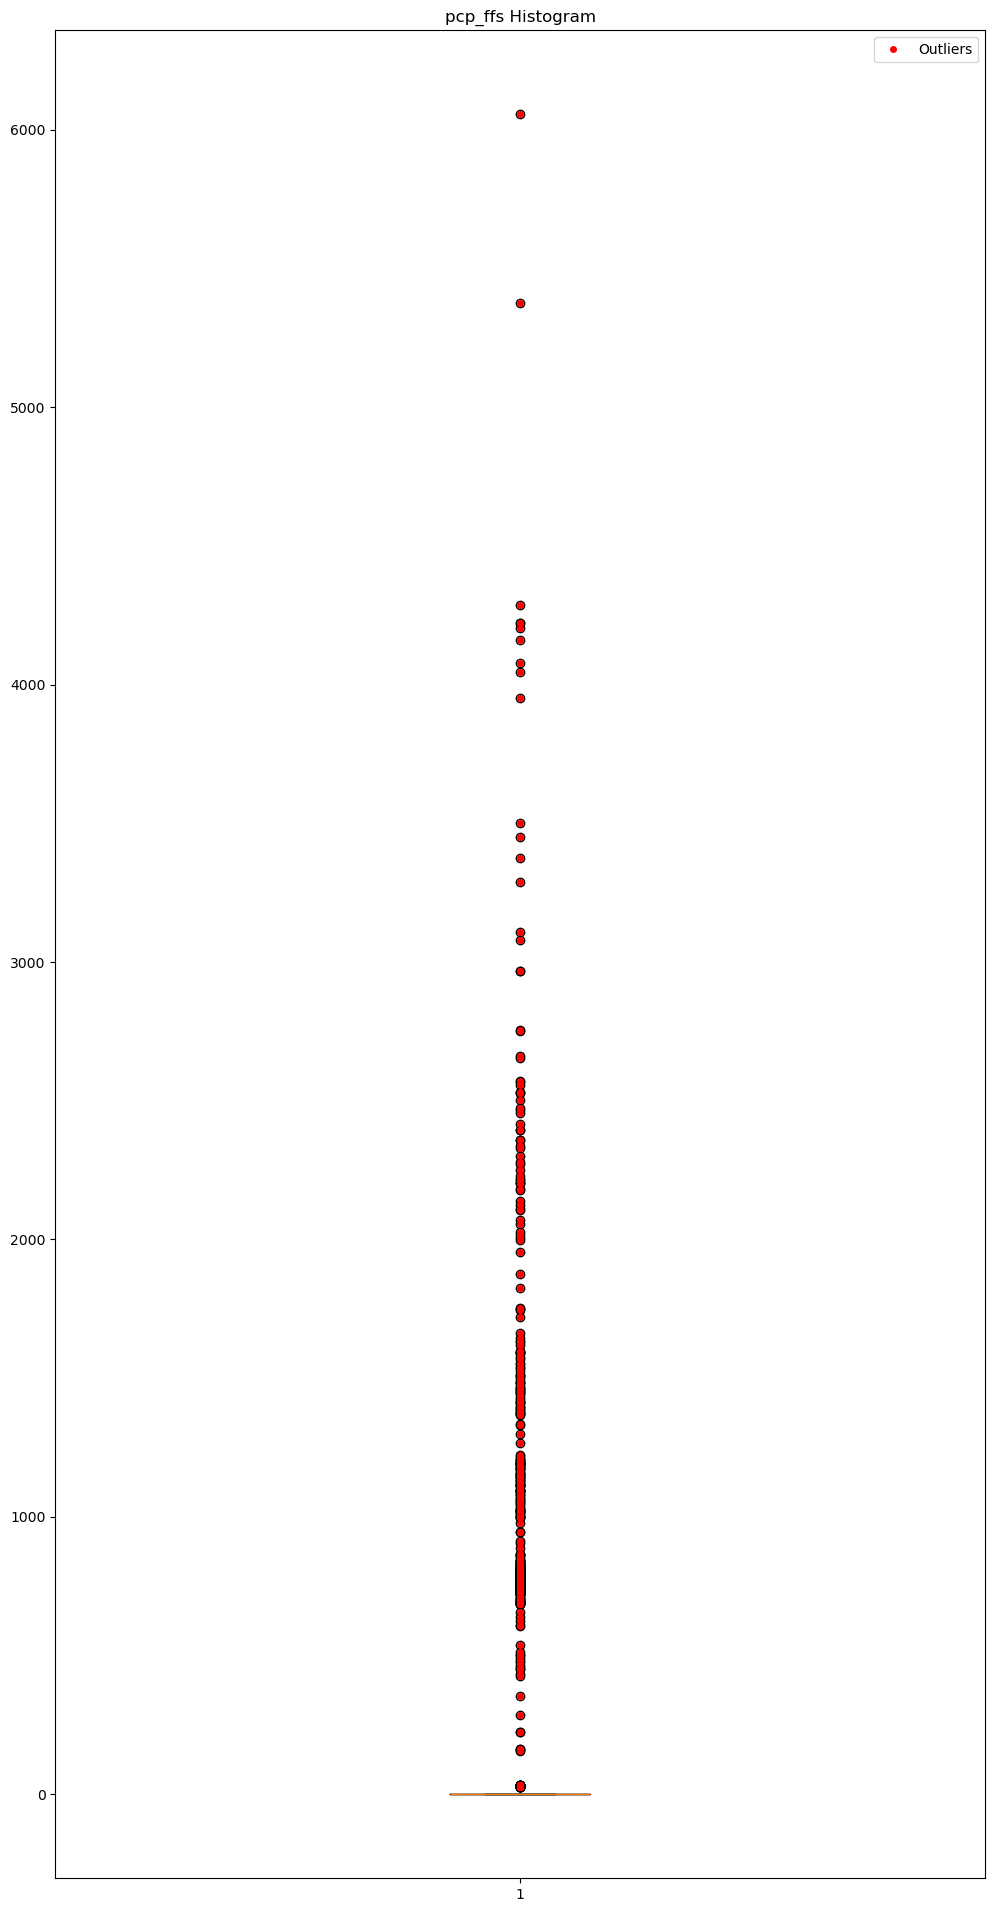

In [33]:
fig, axes = plt.subplots(figsize=(12, 24))
plt.boxplot(insurance_data["pcp_ffs"])

pcp_ffs_outliers = []
for i, data in enumerate(insurance_data["pcp_ffs"]):
    if predictions_pcp_ffs[i] == -1:
        pcp_ffs_outliers.append(data)

plt.plot(np.ones(len(pcp_ffs_outliers)), pcp_ffs_outliers, "ro", markersize=4, label="Outliers")
plt.legend()
plt.title("pcp_ffs Histogram")
plt.show()

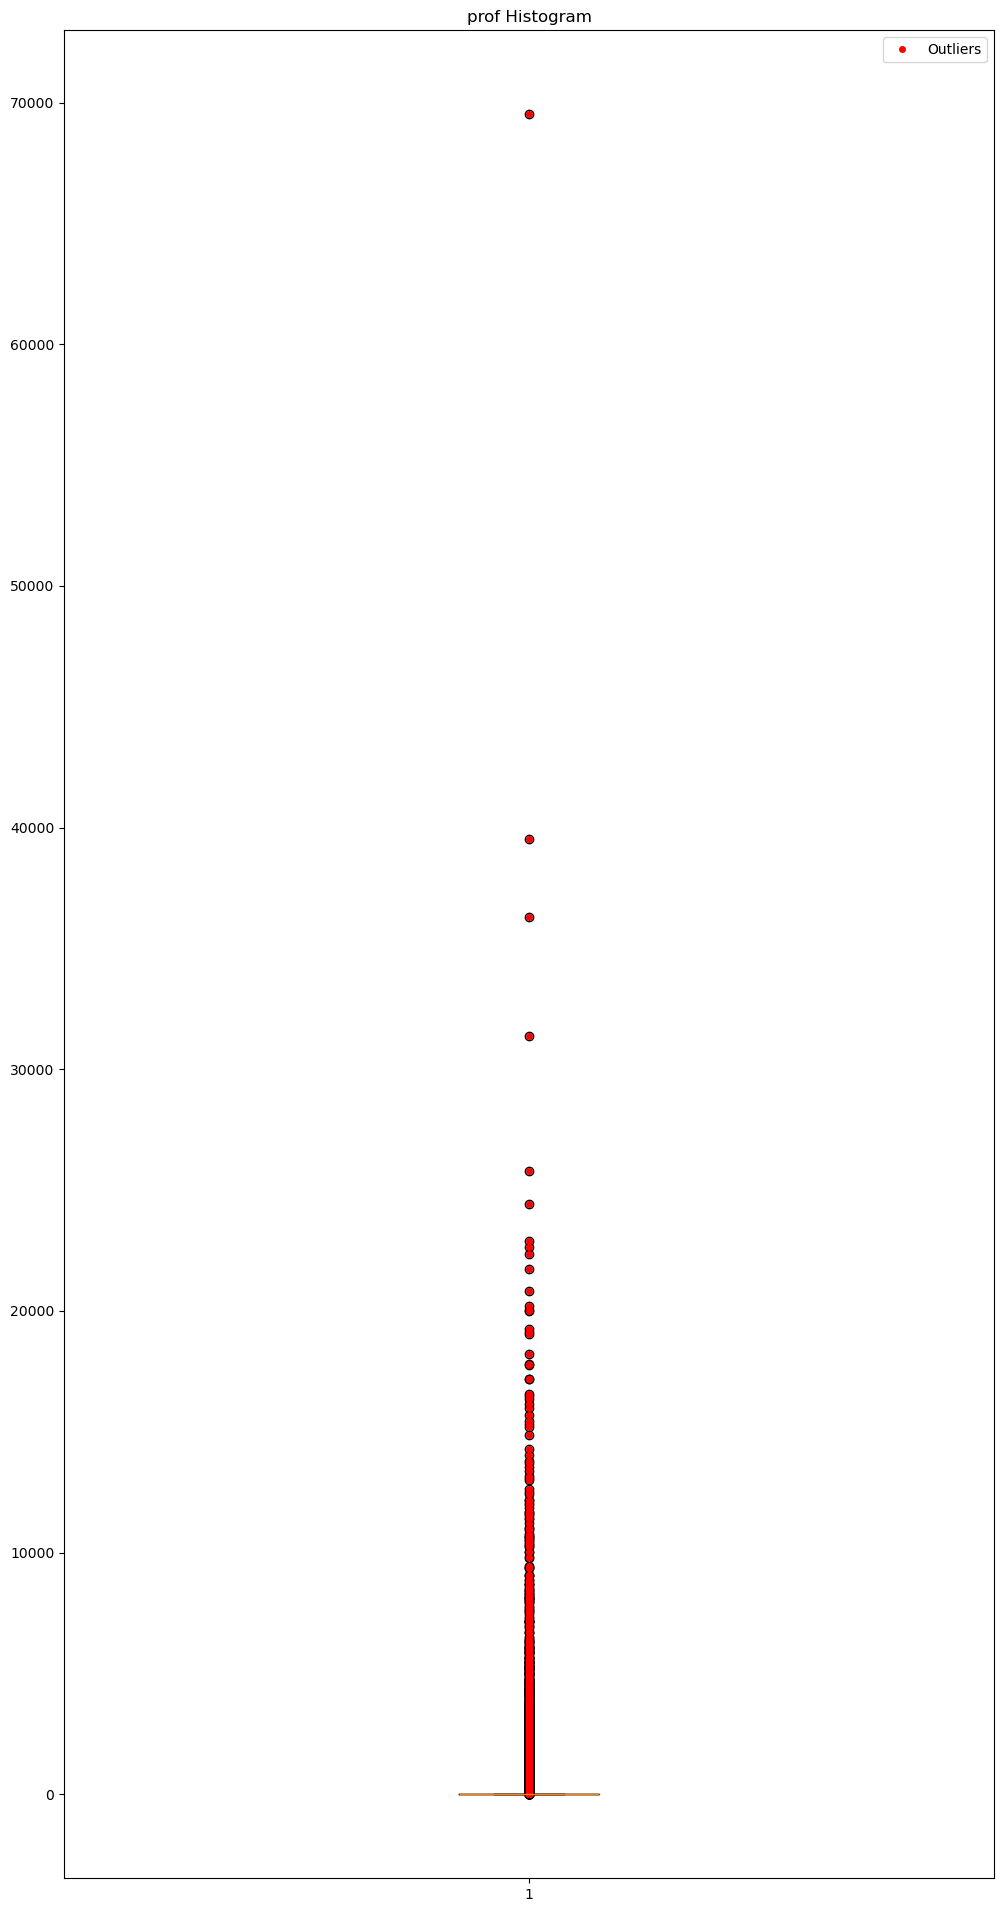

In [36]:
fig, axes = plt.subplots(figsize=(12, 24))
plt.boxplot(insurance_data["prof"])

pcp_prof_outliers = []
for i, data in enumerate(insurance_data["prof"]):
    if predictions_prof[i] == -1:
        pcp_prof_outliers.append(data)

plt.plot(np.ones(len(pcp_prof_outliers)), pcp_prof_outliers, "ro", markersize=4, label="Outliers")
plt.legend()
plt.title("prof Histogram")
plt.show()